In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy

tfb = tfp.bijectors
tfd=tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [2]:
## define some numbers
Number_para = 15
obs_N = 15
number_burnin = 1000
number_sample = 2000
steps_gradient_decent = 100

In [3]:
def constant64(i):
    return(tf.constant(i,dtype = tf.float64))

In [4]:
pi = constant64(m.pi) # define PI in Tensorflow form

In [5]:
depth = constant64(-40)
thickness = constant64(2)

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [6]:
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)


def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))


def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)


def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**2+z[p]**2))


def Z(x,z,p1,p2):
    
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],0.)), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],0.))):
        return(0.)

    elif tf.equal(x[p1], x[p2]):
        return((x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return(Z_result)


def g(x,z,loc):

    G = constant64(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = constant64(2000.)        # density difference   kg/m^3

    _x = x-loc[0]
    _z = z-loc[1]

    Z_sum = constant64(0.)

    for i in tf.range(_x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)


def grav(x,z):

    thick = thickness

    x_obv = tf.linspace(constant64(-70.),constant64(70.),obs_N)
    y_obv = tf.zeros(tf.shape(x_obv),dtype = tf.float64)
    obv = tf.stack((x_obv,y_obv),axis = 1)

    gravity = tf.TensorArray(tf.float64, size=obv.shape[0])

    j = tf.constant(0)
    for i in obv:
        gravity=gravity.write(j,-g(x,z,i))
        j = tf.add(j,1)
    return tf.reshape(gravity.stack(),shape = [obs_N])



def joint_log_post(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood

    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_prior.log_prob(_control_position)
          +mvn_likelihood.log_prob(D))

def negative_log_posterior(D,_control_position):
    return -joint_log_post(D,_control_position)

Define the Prior and likelihood distribution

In [7]:
# prior
mu_prior = -60.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 10.*tf.eye(Number_para,dtype = tf.float64)

# likelihood
sig_e = constant64(0.00000001)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

In [8]:
tf.random.set_seed(8)
control_position = tf.random.normal([Number_para],depth,7,dtype = tf.float64)
control_index = tf.linspace(constant64(-70),constant64(70),Number_para)

M = 10

fix_point1 = tf.transpose(tf.stack([tf.linspace(constant64(-150),constant64(-80),M),depth*tf.ones(M,dtype = tf.float64)]))
fix_point2 = tf.transpose(tf.stack([tf.linspace(constant64(80),constant64(150),M),depth*tf.ones(M,dtype = tf.float64)]))


def GaussianProcess_model(_control_index,_control_position,visual = False,resolution = None):
    if resolution is None:
        resolution=3
    points = tf.stack([_control_index,_control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

    observation_index_points = tf.reshape(points[:,0],[Number_para+2*M,1])
    amplitude = tfp.util.TransformedVariable(
      10, tfb.Exp(), dtype=tf.float64, name='amplitude')
    length_scale = tfp.util.TransformedVariable(
      1000, tfb.Exp(), dtype=tf.float64, name='length_scale')
    kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

    observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-50), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

    # We'll use an unconditioned GP to train the kernel parameters.
    gp = tfd.GaussianProcess(
        kernel=kernel,
        index_points=observation_index_points,
        observation_noise_variance=observation_noise_variance)
    
    optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
    @tf.function
    def optimize():
        with tf.GradientTape() as tape:
            loss = -gp.log_prob(points[:,1])
        grads = tape.gradient(loss, gp.trainable_variables)
        optimizer.apply_gradients(zip(grads, gp.trainable_variables))
        return loss
    # First train the model, then draw and plot posterior samples.
    for i in range(1000):
        neg_log_likelihood_ = optimize()

    ### discretize the geometry
    if visual == True:
        visual_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],200),axis =1)
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)
    
    tf.random.set_seed(1)
    model_position = gprm.sample(1,seed = 1)
    
    if visual == True:
        gprm_visual = tfd.GaussianProcessRegressionModel(
            kernel=kernel,
            index_points=visual_index,
            observation_index_points=observation_index_points,
            observations=points[:,1],
            observation_noise_variance=observation_noise_variance)
        tf.random.set_seed(1)
        visual_position = gprm_visual.sample(1,seed =1)
        plt.figure(figsize = (14,7))
        plt.scatter(_control_index,_control_position,c = 'r')
        plt.plot(tf.transpose(visual_index).numpy()[0],visual_position[0])
        
    model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,axis = [-1])],axis = -1)],
                                         shape = [model_position.shape[1]*2,1])

    model_index_complete = tf.concat([model_index,tf.reverse(model_index,axis = [0])],axis = 0)
    
    return model_index_complete,model_position_complete



In [9]:
def GaussianProcess_model_plot(control_index,control_position,ax = None,resolution = None,**args):
    if resolution is None:
        resolution=3
    if ax is None:
        f,ax = plt.subplots()
        
    points = tf.stack([control_index,control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

    observation_index_points = tf.reshape(points[:,0],[Number_para+2*M,1])
    amplitude = tfp.util.TransformedVariable(
      10, tfb.Exp(), dtype=tf.float64, name='amplitude')
    length_scale = tfp.util.TransformedVariable(
      100, tfb.Exp(), dtype=tf.float64, name='length_scale')
    kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

    observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-500), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

    # We'll use an unconditioned GP to train the kernel parameters.
    gp = tfd.GaussianProcess(
        kernel=kernel,
        index_points=observation_index_points,
        observation_noise_variance=observation_noise_variance)
    
    optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
    @tf.function
    def optimize():
        with tf.GradientTape() as tape:
            loss = -gp.log_prob(points[:,1])
        grads = tape.gradient(loss, gp.trainable_variables)
        optimizer.apply_gradients(zip(grads, gp.trainable_variables))
        return loss
    # First train the model, then draw and plot posterior samples.
    for i in range(1000):
        neg_log_likelihood_ = optimize()

    ### discretize the geometry

    visual_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],100),axis =1)
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)
    
    tf.random.set_seed(1)
    model_position = gprm.sample(1,seed = 1)
    

    gprm_visual = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=visual_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)
    visual_position = gprm_visual.sample(1,seed =1)
    ax.scatter(control_index,control_position,c = 'r',**args)
    ax.plot(tf.transpose(visual_index).numpy()[0],visual_position[0],'b',**args)
    
    return 

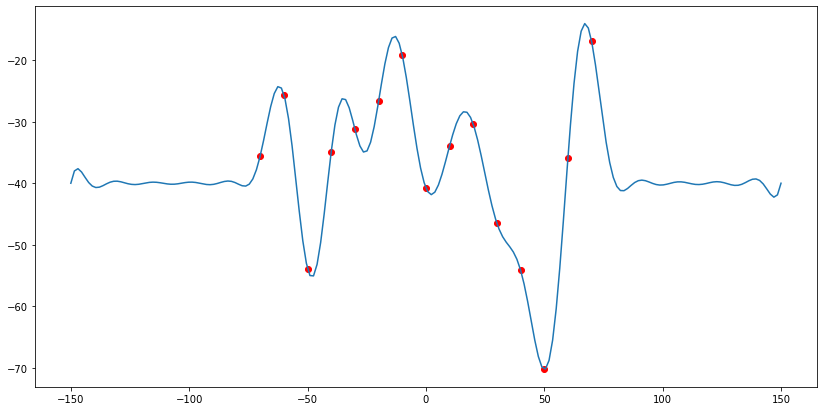

In [11]:
## generate some true observation gravity data

True_position = tf.random.normal([Number_para],depth,10,dtype = tf.float64)

x_true,z_true = GaussianProcess_model(control_index,True_position,visual =True,resolution=4)
D = grav(x_true,z_true)

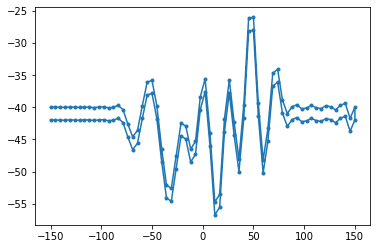

In [27]:
plt.plot(x_true,z_true,'.-')

In [28]:
def joint_log_post(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood

    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_prior.log_prob(_control_position)
          +mvn_likelihood.log_prob(D))

#### create some noise

In [41]:
tf.random.set_seed(1234)
noise = tf.random.normal([obs_N],mean =constant64(0),stddev =sig_e,seed = 1,dtype = tf.float64)

In [42]:
D_noise = D+noise

In [43]:
def grav_calculate(x,z,x_obs=None,Number_=obs_N ,R=70,ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(x,z,i))
    gravity = np.array(gravity)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')
#     ax.set_ylim(4e-6,10e-6)
    ax.set_xlim(-70,70)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

### Full Gravity response at surface

array([[1.31454203e-06],
       [1.32790682e-06],
       [1.33139251e-06],
       [1.32615776e-06],
       [1.32092686e-06],
       [1.32226921e-06],
       [1.32886095e-06],
       [1.33594101e-06],
       [1.34276551e-06],
       [1.35492193e-06],
       [1.37681942e-06],
       [1.40206034e-06],
       [1.40931673e-06],
       [1.38893878e-06],
       [1.35687470e-06]])

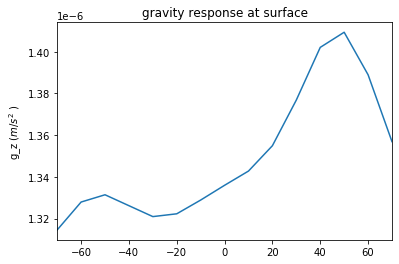

In [32]:
grav_calculate(x_true,z_true)

## Plotting function

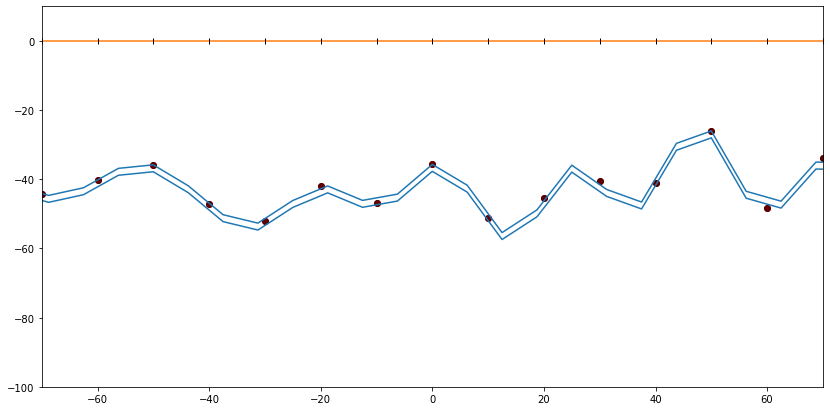

In [33]:
def Draw_inter(_control_index,_control_position,x_true = None,z_true = None,R = 70, ax = None):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is None:
        x_true,z_true = GaussianProcess_model(_control_index,_control_position)
    ax.scatter(control_index,_control_position, c = 'red')
    ax.scatter(control_index,True_position, c = 'black',alpha = 0.6)
    ax.plot(x_true,z_true)
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N))
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|')
    ax.set_ylim(-100,10)
    ax.set_xlim(-R,R)
Draw_inter(control_index,True_position)

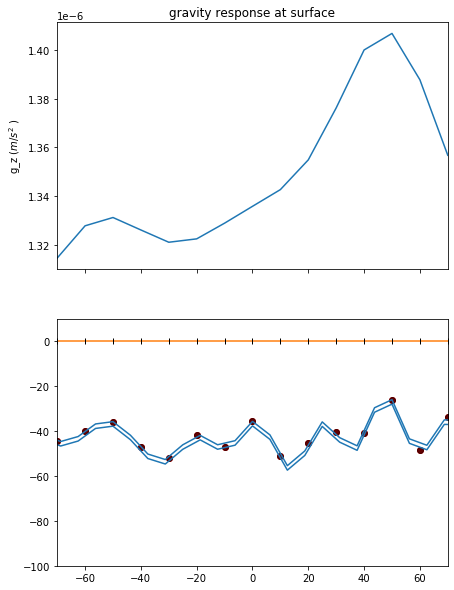

In [34]:
def Draw(_control_index,_control_position,ax = None):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    _x,_z = GaussianProcess_model(_control_index,_control_position)
    grav_calculate(_x,_z,ax = ax[0])
    Draw_inter(_control_index,_control_position,ax = ax[1])
Draw(control_index,True_position)

In [35]:
x_obs = np.linspace(-70,70,obs_N)

### Gravity response at receivers

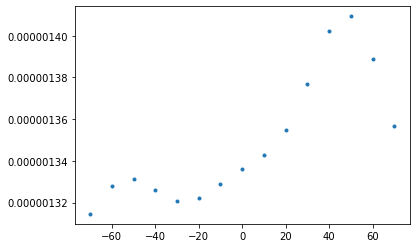

In [36]:
plt.plot(x_obs,D,'.')

#### Gradient decent

In [37]:
mu = tf.random.uniform([Number_para],minval = -50,maxval = -30,seed = 1,dtype = tf.float64) # initial parameters

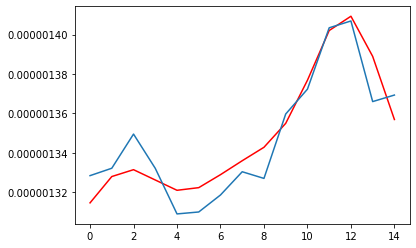

In [44]:
f,ax = plt.subplots()
ax.plot(D,'r')
ax.plot(D_noise)


In [45]:
steps_gradient_decent = 50

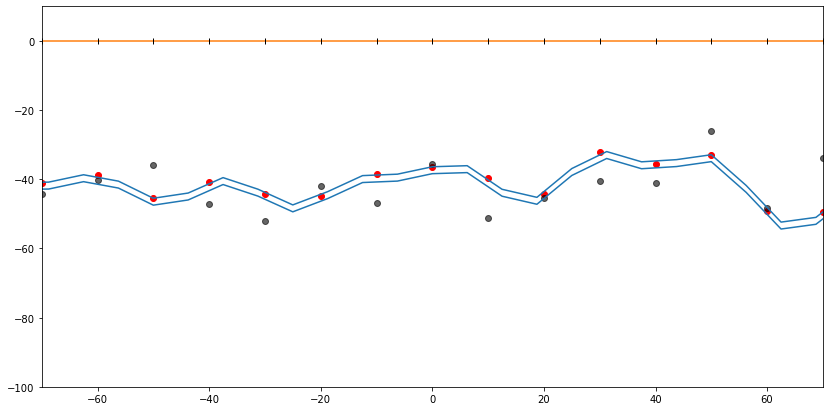

In [46]:
Draw_inter(control_index,mu)

loss tf.Tensor(206.41802516045206, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.98933132  1.86140268  2.25326287  4.2070707   5.16388798  6.84065737
  9.49000993 11.37563514  9.78221587  7.34602251  7.47886451  2.56816891
 -0.97243193 -2.02885373 -2.01470556], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-41.2118661  -38.85657659 -45.71696564 -41.18360165 -44.6995541
 -45.50906295 -39.52324397 -37.52993744 -40.74194716 -44.88923128
 -32.86268573 -35.78590948 -32.81634586 -48.94373897 -49.32844858], shape=(15,), dtype=float64)
Iteration 0


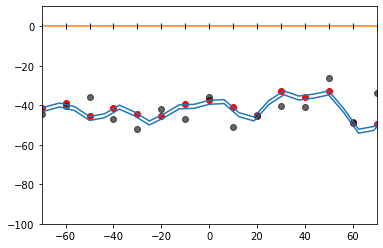

loss tf.Tensor(156.55428059058983, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.12731547  1.84195692  2.02197958  3.67921143  4.39172407  5.72960408
  7.94002756  9.47635088  8.1603927   6.13524426  6.42226933  2.18536664
 -0.94448333 -1.93481173 -1.85464818], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-41.32459765 -39.04077228 -45.9191636  -41.5515228  -45.13872651
 -46.08202335 -40.31724672 -38.47757253 -41.55798643 -45.50275571
 -33.50491266 -36.00444615 -32.72189753 -48.75025779 -49.14298376], shape=(15,), dtype=float64)
Iteration 1


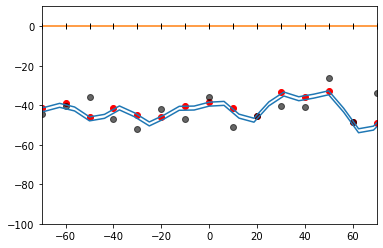

loss tf.Tensor(120.84439880213074, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.2107804   1.78951123  1.79882932  3.21795997  3.74468318  4.83133933
  6.71765687  8.00537628  6.89721676  5.18030273  5.5814555   1.87746259
 -0.91249908 -1.84905595 -1.71335824], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-41.44567569 -39.2197234  -46.09904653 -41.8733188  -45.51319483
 -46.56515729 -40.98901241 -39.27811016 -42.2477081  -46.02078598
 -34.06305821 -36.19219241 -32.63064762 -48.5653522  -48.97164794], shape=(15,), dtype=float64)
Iteration 2


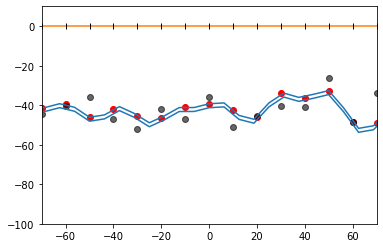

loss tf.Tensor(94.69394082275468, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.25762233  1.71812279  1.58929192  2.81432856  3.19724293  4.09265646
  5.73211774  6.83658297  5.88941004  4.41110912  4.90025711  1.62689349
 -0.87643655 -1.76953137 -1.58673216], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-41.57143792 -39.39153568 -46.25797572 -42.15475165 -45.83291912
 -46.97442293 -41.56222418 -39.96176846 -42.83664911 -46.46189689
 -34.55308392 -36.35488176 -32.54300396 -48.38839906 -48.81297472], shape=(15,), dtype=float64)
Iteration 3


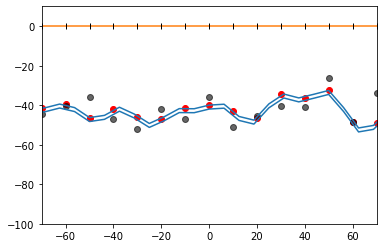

loss tf.Tensor(75.20230237549106, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.27960785  1.63742311  1.39608444  2.46120683  2.73098469  3.4774075
  4.92434699  5.88924758  5.06999057  3.78114568  4.33944888  1.42113955
 -0.83753339 -1.69523418 -1.47216058], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-41.69939871 -39.55527799 -46.39758417 -42.40087233 -46.10601759
 -47.32216368 -42.05465888 -40.55069322 -43.34364816 -46.84001146
 -34.98702881 -36.49699571 -32.45925062 -48.21887564 -48.66575866], shape=(15,), dtype=float64)
Iteration 4


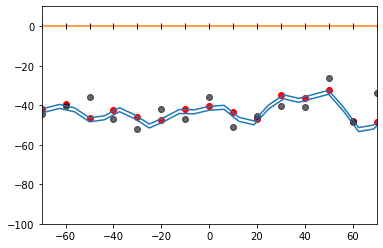

loss tf.Tensor(60.46159636971794, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.28408614  1.55285828  1.21930466  2.15164264  2.33115605  2.95971903
  4.25322316  5.10962199  4.39378097  3.25839304  3.87210034  1.25070588
 -0.7967439  -1.62518823 -1.36821065], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-41.82780732 -39.71056382 -46.51951463 -42.6160366  -46.33913319
 -47.61813559 -42.4799812  -41.06165541 -43.78302626 -47.16585076
 -35.37423884 -36.6220663  -32.37957623 -48.05635682 -48.5289376 ], shape=(15,), dtype=float64)
Iteration 5


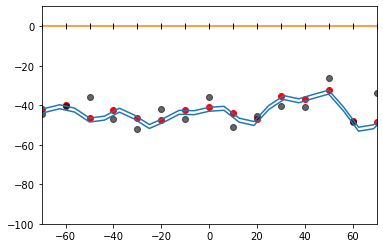

loss tf.Tensor(49.17445974113289, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.27716658  1.46822374  1.05928836  1.88018628  1.98716456  2.52054258
  3.69010293  4.45964675  3.82894202  2.81959888  3.47806634  1.10832488
 -0.75500711 -1.55953203 -1.27292123], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-41.95552398 -39.8573862  -46.62544347 -42.80405523 -46.53784965
 -47.87018984 -42.84899149 -41.50762009 -44.16592046 -47.44781065
 -35.72204547 -36.73289879 -32.30407552 -47.90040362 -48.40164547], shape=(15,), dtype=float64)
Iteration 6


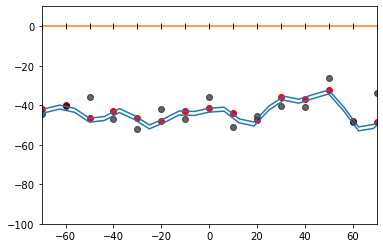

loss tf.Tensor(40.43858187684353, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.26185176  1.38562382  0.91454527  1.64170728  1.68962968  2.14557941
  3.21322245  3.91246466  3.35239935  2.44806464  3.14293377  0.98858254
 -0.71314461 -1.49747133 -1.1858692 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-42.08170916 -39.99594858 -46.716898   -42.96822595 -46.70681262
 -48.08474778 -43.17031374 -41.89886656 -44.5011604  -47.69261712
 -36.03633885 -36.83175704 -32.23276106 -47.75065648 -48.28305855], shape=(15,), dtype=float64)
Iteration 7


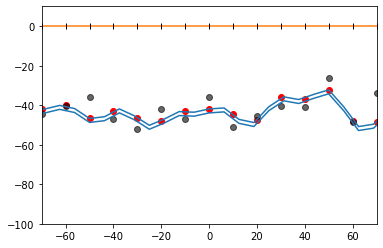

loss tf.Tensor(33.61137881448565, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.2408357   1.30650035  0.7840867   1.43208782  1.43149874  1.82379359
  2.80653487  3.44790491  2.94695032  2.13101656  2.8554723   0.88717546
 -0.67184258 -1.43882926 -1.1062151 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-42.20579273 -40.12659861 -46.79530667 -43.11143474 -46.84996249
 -48.26712714 -43.45096722 -42.24365705 -44.79585543 -47.90571877
 -36.32188608 -36.92047459 -32.1655768  -47.60677356 -48.17243704], shape=(15,), dtype=float64)
Iteration 8


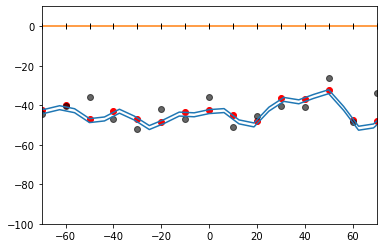

loss tf.Tensor(28.226723458486646, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.21638003  1.23154706  0.66703043  1.24766991  1.20717925  1.54637489
  2.45781215  3.05054568  2.59955907  1.85856207  2.60706072  0.80068907
 -0.63145025 -1.38366867 -1.03286997], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-42.32743073 -40.24975332 -46.86200971 -43.23620173 -46.97068042
 -48.42176463 -43.69674844 -42.54871161 -45.05581134 -48.09157498
 -36.58259215 -37.00054349 -32.10243178 -47.46840669 -48.06915005], shape=(15,), dtype=float64)
Iteration 9


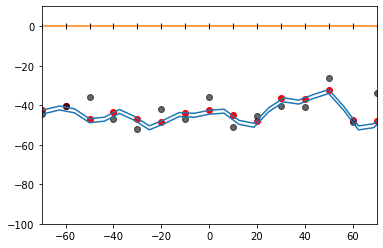

loss tf.Tensor(23.943247611869253, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.18970351  1.16113195  0.56210985  1.08530642  1.01180388  1.30638195
  2.15729595  2.70864696  2.30010266  1.62310224  2.39101743  0.72648765
 -0.59232565 -1.33172945 -0.96532491], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-42.44640108 -40.36586651 -46.9182207  -43.34473237 -47.0718608
 -48.55240283 -43.91247803 -42.81957631 -45.2858216  -48.2538852
 -36.8216939  -37.07319226 -32.04319921 -47.33523375 -47.97261755], shape=(15,), dtype=float64)
Iteration 10


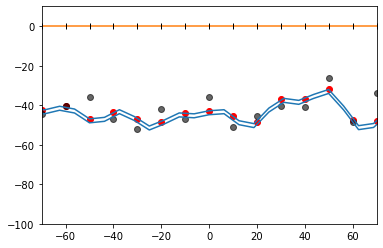

loss tf.Tensor(20.507082338304997, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.1617804   1.09536819  0.46820688  0.94229137  0.84139167  1.09817982
  1.89727135  2.41294307  2.04061705  1.41858217  2.20202292  0.66244421
 -0.55470094 -1.2828489  -0.9030315 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-42.56257912 -40.47540333 -46.96504138 -43.43896151 -47.15599997
 -48.66222081 -44.10220517 -43.06087062 -45.48988331 -48.39574342
 -37.04189619 -37.13943668 -31.98772912 -47.20694886 -47.88231441], shape=(15,), dtype=float64)
Iteration 11


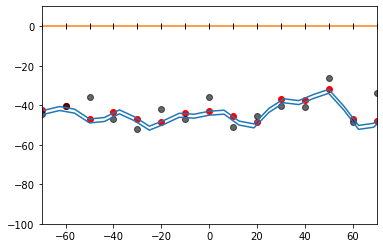

loss tf.Tensor(17.727378827777443, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.13342812  1.03418035  0.38434721  0.8162751   0.69265816  0.91713172
  1.67155912  2.15600817  1.81476027  1.24010492  2.03581048  0.60681487
 -0.51869029 -1.23694843 -0.84539391], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-42.67592193 -40.57882137 -47.0034761  -43.52058902 -47.22526579
 -48.75393398 -44.26936108 -43.27647143 -45.67135934 -48.51975391
 -37.24547724 -37.20011817 -31.93586009 -47.08325401 -47.79777501], shape=(15,), dtype=float64)
Iteration 12


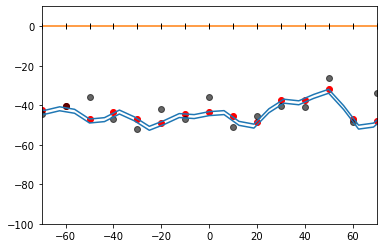

loss tf.Tensor(15.460705260774375, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.10463705  0.9775234   0.30921898  0.70524771  0.56254124  0.75950801
  1.47491685  1.93205591  1.61732911  1.08389459  1.8889195   0.55836891
 -0.48453351 -1.19352048 -0.7924454 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-42.78638564 -40.67657371 -47.034398   -43.59111379 -47.28151991
 -48.82988478 -44.41685277 -43.46967703 -45.83309225 -48.62814337
 -37.43436919 -37.25595506 -31.88740674 -46.96390196 -47.71853047], shape=(15,), dtype=float64)
Iteration 13


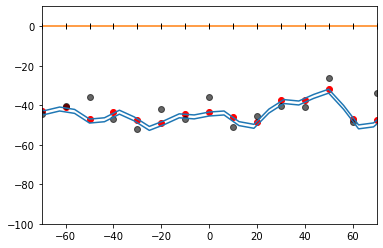

loss tf.Tensor(13.596745413182902, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.07587626  0.925194    0.24202114  0.60746726  0.44870556  0.62212129
  1.30320496  1.73618445  1.44412413  0.9466793   1.75848397  0.5159396
 -0.45227423 -1.15247924 -0.74373479], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-42.89397326 -40.76909311 -47.05860012 -43.65186051 -47.32639047
 -48.89209691 -44.54717326 -43.64329547 -45.97750466 -48.7228113
 -37.61021758 -37.30754902 -31.84217932 -46.84865404 -47.64415699], shape=(15,), dtype=float64)
Iteration 14


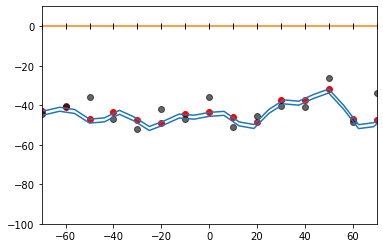

loss tf.Tensor(12.048850266640073, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.04830977  0.87670133  0.18251658  0.52128683  0.34950663  0.50209074
  1.15324564  1.56406315  1.29182916  0.82548781  1.64223258  0.47833894
 -0.42155959 -1.11430703 -0.69799379], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-42.99880424 -40.85676324 -47.07685177 -43.7039892  -47.36134113
 -48.94230598 -44.66249782 -43.79970179 -46.10668758 -48.80536008
 -37.77444084 -37.35538291 -31.80002336 -46.73722334 -47.57435762], shape=(15,), dtype=float64)
Iteration 15


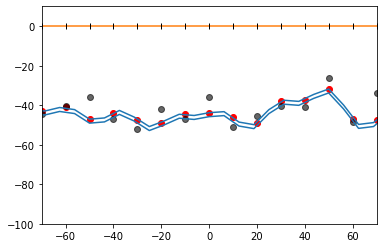

loss tf.Tensor(10.75440139885697, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.02064385  0.8321032   0.12902264  0.44543832  0.26251776  0.39739743
  1.02166259  1.41284599  1.1573585   0.71858094  1.53816852  0.44527725
 -0.39284029 -1.07784895 -0.65627077], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.10086863 -40.93997356 -47.08975404 -43.74853303 -47.38759291
 -48.98204573 -44.76466408 -43.94098639 -46.22242343 -48.87721817
 -37.92825769 -37.39991064 -31.76073933 -46.62943844 -47.50873054], shape=(15,), dtype=float64)
Iteration 16


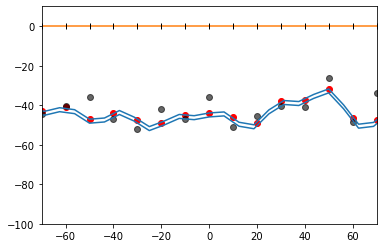

loss tf.Tensor(9.660137782970253, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.99424329  0.79087867  0.08168661  0.37869597  0.18677424  0.30591594
  0.90638291  1.27933736  1.03846981  0.62366494  1.44469748  0.4156983
 -0.36569305 -1.04382158 -0.61715127], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.20029296 -41.01906143 -47.0979227  -43.78640263 -47.40627033
 -49.01263732 -44.85530237 -44.06892012 -46.32627041 -48.93958467
 -38.07272744 -37.44148047 -31.72417002 -46.52505628 -47.44701541], shape=(15,), dtype=float64)
Iteration 17


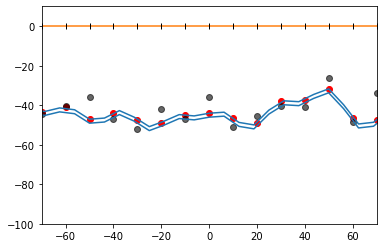

loss tf.Tensor(8.72772829929852, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.96839677  0.75289857  0.03939235  0.32001256  0.12060156  0.22607554
  0.80508254  1.16141813  0.93302897  0.5394276   1.3604435   0.3893675
 -0.34025683 -1.0115526  -0.58103819], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.29713263 -41.09435128 -47.10186193 -43.81840388 -47.41833049
 -49.03524488 -44.93581063 -44.18506194 -46.4195733  -48.99352743
 -38.20877179 -37.48041722 -31.69014434 -46.42390102 -47.38891159], shape=(15,), dtype=float64)
Iteration 18


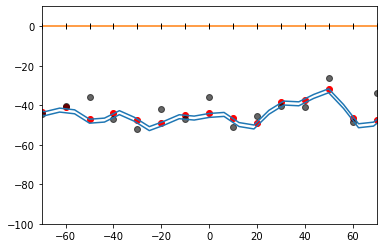

loss tf.Tensor(7.924940488139896, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.94368995  0.71780052  0.00195135  0.26846094  0.0630858   0.15637515
  0.71613854  1.05692243  0.83938575  0.46433959  1.2842659   0.36564728
 -0.31630043 -0.98128922 -0.54721092], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.39150163 -41.16613134 -47.10205707 -43.84524998 -47.42463907
 -49.05088239 -45.00742448 -44.29075418 -46.50351188 -49.03996139
 -38.33719838 -37.51698194 -31.6585143  -46.3257721  -47.3341905 ], shape=(15,), dtype=float64)
Iteration 19


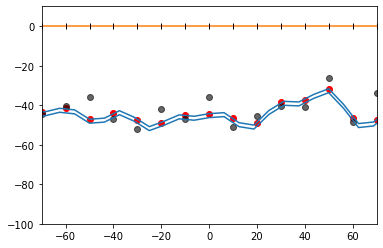

loss tf.Tensor(7.229136494633764, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.91921301  0.68554373 -0.03170825  0.22326763  0.01282201  0.0957098
  0.63774375  0.96442608  0.75592153  0.39756816  1.21511277  0.34450605
 -0.29405041 -0.95226357 -0.51630813], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.48342293 -41.23468571 -47.09888624 -43.86757674 -47.42592127
 -49.06045337 -45.07119886 -44.38719679 -46.57910403 -49.0797182
 -38.45870966 -37.55143255 -31.62910926 -46.23054575 -47.28255969], shape=(15,), dtype=float64)
Iteration 20


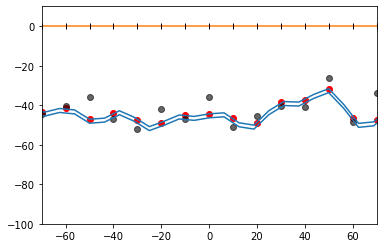

loss tf.Tensor(6.6171102191137265, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.8967343   0.65549374 -0.06091988  0.1836184  -0.03032099  0.04272871
  0.56909877  0.88191864  0.68166305  0.33753056  1.15229103  0.32500471
 -0.27279805 -0.92559061 -0.48645505], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.57309636 -41.30023508 -47.09279426 -43.88593858 -47.42288917
 -49.06472624 -45.12810874 -44.47538865 -46.64727034 -49.11347126
 -38.57393876 -37.58393302 -31.60182945 -46.13798668 -47.23391418], shape=(15,), dtype=float64)
Iteration 21


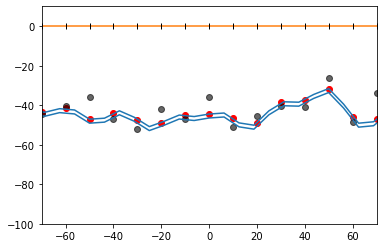

loss tf.Tensor(6.078684773012185, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.87381023  0.62798204 -0.0875941   0.14900074 -0.06814895 -0.0031364
  0.50834636  0.80888472  0.61512387  0.28420409  1.09486233  0.30775875
 -0.25332064 -0.89947124 -0.45977201], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.66047738 -41.36303329 -47.08403485 -43.90083865 -47.41607427
 -49.0644126  -45.17894337 -44.55627712 -46.70878272 -49.14189167
 -38.68342499 -37.61470889 -31.57649739 -46.04803956 -47.18793698], shape=(15,), dtype=float64)
Iteration 22


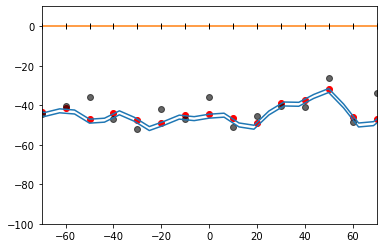

loss tf.Tensor(5.596937273061229, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.85257628  0.60234362 -0.11073533  0.11875901 -0.10043171 -0.04302094
  0.45511709  0.74357898  0.55571154  0.23612165  1.04238368  0.29176019
 -0.23478244 -0.87529486 -0.43407244], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.74573501 -41.42326765 -47.07296131 -43.91271455 -47.4060311
 -49.06011051 -45.22445508 -44.63063502 -46.76435388 -49.16550383
 -38.78766336 -37.64388491 -31.55301914 -45.96051007 -47.14452974], shape=(15,), dtype=float64)
Iteration 23


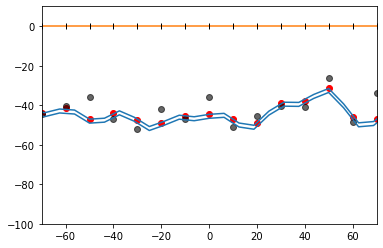

loss tf.Tensor(5.1635871889323255, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.83222363  0.57852925 -0.13116639  0.09238726 -0.12810951 -0.07755965
  0.40832324  0.68528015  0.50250211  0.19291619  0.9942792   0.27712487
 -0.21732379 -0.85243312 -0.40988049], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.82895737 -41.48112058 -47.05984467 -43.92195328 -47.39322015
 -49.05235454 -45.2652874  -44.69916304 -46.81460409 -49.18479545
 -38.88709128 -37.6715974  -31.53128676 -45.87526676 -47.10354169], shape=(15,), dtype=float64)
Iteration 24


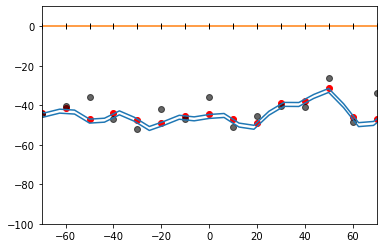

loss tf.Tensor(4.77304211290064, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.8118018   0.55661518 -0.14972142  0.06952892 -0.15208993 -0.10721635
  0.36693607  0.63345034  0.45460414  0.1543404   0.94993827  0.26401007
 -0.20126831 -0.83014873 -0.38800997], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.91013755 -41.53678209 -47.04487253 -43.92890617 -47.37801116
 -49.04163291 -45.30198101 -44.76250807 -46.8600645  -49.20022949
 -38.98208511 -37.69799841 -31.51115993 -45.79225189 -47.06474069], shape=(15,), dtype=float64)
Iteration 25


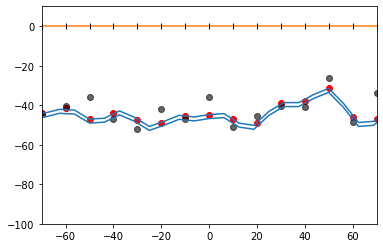

loss tf.Tensor(4.415733732195434, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.79267136  0.53613943 -0.16579578  0.04972299 -0.17226316 -0.13275196
  0.3306906   0.5869558   0.41163802  0.11943978  0.90910242  0.25176709
 -0.18601955 -0.80932159 -0.36700185], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-43.98940469 -41.59039604 -47.02829295 -43.93387847 -47.36078484
 -49.02835771 -45.33505007 -44.82120365 -46.9012283  -49.21217347
 -39.07299535 -37.72317512 -31.49255798 -45.71131973 -47.02804051], shape=(15,), dtype=float64)
Iteration 26


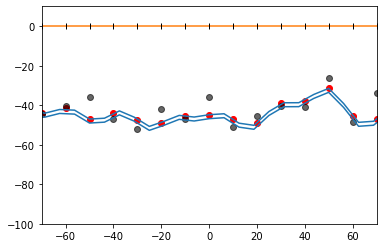

loss tf.Tensor(4.086721619719157, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.77462534  0.51695804 -0.17974497  0.03258076 -0.18912628 -0.1546648
  0.29896204  0.54520747  0.3730565   0.08785361  0.87143777  0.24035985
 -0.17150693 -0.78976517 -0.34683693], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.06686722 -41.64209184 -47.01031846 -43.93713655 -47.34187221
 -49.01289123 -45.36494627 -44.8757244  -46.93853395 -49.22095883
 -39.16013913 -37.7472111  -31.47540729 -45.63234321 -46.99335681], shape=(15,), dtype=float64)
Iteration 27


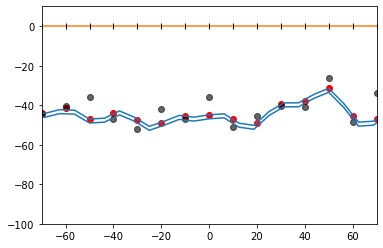

loss tf.Tensor(3.7841722114481513, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.75671034  0.4991797  -0.19232381  0.01787254 -0.20342503 -0.17322405
  0.27096795  0.50793407  0.3381984   0.0595157   0.83648023  0.23000648
 -0.15807515 -0.77076648 -0.32836608], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.14253826 -41.69200981 -46.99108608 -43.9389238  -47.32152971
 -48.99556883 -45.39204307 -44.9265178  -46.97235379 -49.2269104
 -39.24378715 -37.77021175 -31.45959977 -45.55526657 -46.9605202 ], shape=(15,), dtype=float64)
Iteration 28


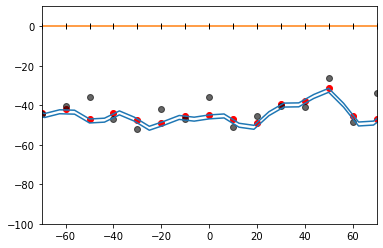

loss tf.Tensor(3.5041355360366424, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.73915535  0.48264063 -0.20355159  0.00531255 -0.21537633 -0.18885174
  0.24632977  0.47456832  0.30668542  0.03400712  0.80397524  0.22052136
 -0.14556532 -0.75243609 -0.31124827], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.21645379 -41.74027387 -46.97073092 -43.93945505 -47.29999208
 -48.97668365 -45.41667605 -44.97397464 -47.00302234 -49.23031111
 -39.32418468 -37.79226389 -31.44504324 -45.48002296 -46.92939538], shape=(15,), dtype=float64)
Iteration 29


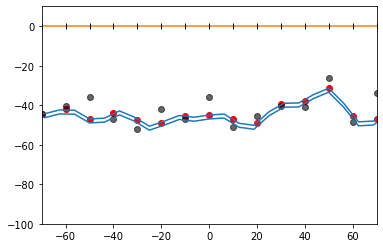

loss tf.Tensor(3.2418429304620133, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.72268385  0.46705453 -0.21313498 -0.00539448 -0.22496033 -0.20200218
  0.22486744  0.44446621  0.27829713  0.01079082  0.77379366  0.21155297
 -0.13360182 -0.73523613 -0.29464471], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.28872218 -41.78697933 -46.94941742 -43.93891561 -47.27749604
 -48.95648343 -45.43916279 -45.01842126 -47.03085205 -49.23139019
 -39.40156404 -37.81341918 -31.43168306 -45.40649934 -46.89993091], shape=(15,), dtype=float64)
Iteration 30


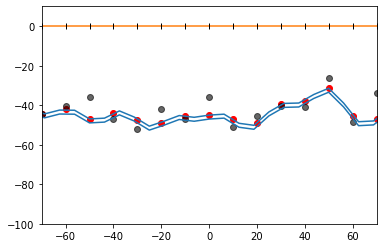

loss tf.Tensor(2.9953283300041846, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.70708318  0.45235099 -0.22133947 -0.01447356 -0.2325144  -0.21295754
  0.20617941  0.41730246  0.25268338 -0.010325    0.74570934  0.2031047
 -0.12218482 -0.71899154 -0.27863463], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.3594305  -41.83221443 -46.92728347 -43.93746825 -47.25424461
 -48.93518768 -45.45978073 -45.0601515  -47.05612039 -49.23035769
 -39.47613498 -37.83372965 -31.41946457 -45.33460019 -46.87206744], shape=(15,), dtype=float64)
Iteration 31


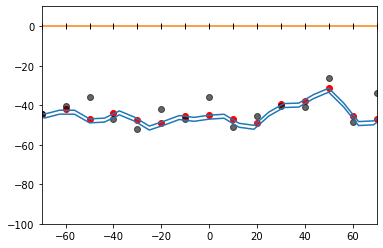

loss tf.Tensor(2.7644867925145036, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.69165807  0.43860735 -0.22869576 -0.02207095 -0.23854083 -0.22187608
  0.18976045  0.39293635  0.22941924 -0.02934881  0.71941605  0.19535295
 -0.11156343 -0.70319136 -0.2638325 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.4285963  -41.87607516 -46.90441389 -43.93526116 -47.23039052
 -48.91300007 -45.47875677 -45.09944514 -47.07906231 -49.22742281
 -39.54807658 -37.85326495 -31.40830823 -45.26428105 -46.84568419], shape=(15,), dtype=float64)
Iteration 32


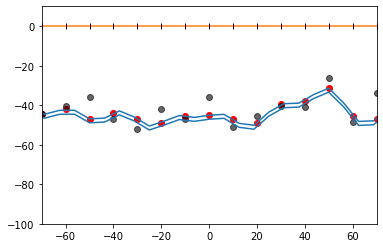

loss tf.Tensor(2.5478221972059316, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.67637906  0.42575292 -0.23531955 -0.02835941 -0.2432419  -0.22899631
  0.17533417  0.3710683   0.20824561 -0.04648387  0.6947374   0.18824575
 -0.10169393 -0.68778442 -0.25017797], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.49623421 -41.91865045 -46.88088194 -43.93242522 -47.20606633
 -48.89010044 -45.49629019 -45.13655197 -47.09988687 -49.22277443
 -39.61755032 -37.87208952 -31.39813884 -45.19550261 -46.8206664 ], shape=(15,), dtype=float64)
Iteration 33


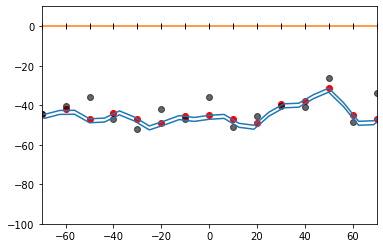

loss tf.Tensor(2.342416445061076, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.66180444  0.4135928  -0.24095778 -0.0335149  -0.24655718 -0.23460513
  0.16282218  0.35127786  0.18904739 -0.06209819  0.67160664  0.18152052
 -0.09229751 -0.67312571 -0.23704518], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.56241465 -41.96000973 -46.85678616 -43.92907373 -47.18141061
 -48.86663993 -45.51257241 -45.17167976 -47.11879161 -49.21656461
 -39.68471098 -37.89024157 -31.38890909 -45.12819004 -46.79696188], shape=(15,), dtype=float64)
Iteration 34


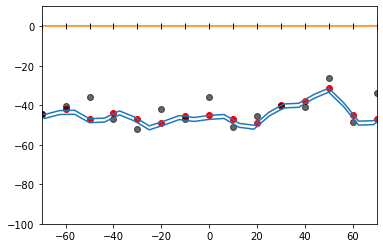

loss tf.Tensor(2.146726188033483, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.64801098  0.40201742 -0.2456516  -0.03770463 -0.24860867 -0.23891896
  0.152043    0.33330268  0.17165938 -0.07637887  0.64992958  0.1751085
 -0.08325851 -0.65925001 -0.22424392], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.62721575 -42.00021148 -46.832221   -43.92530326 -47.15654975
 -48.84274803 -45.52777671 -45.20501002 -47.13595755 -49.20892672
 -39.74970394 -37.90775242 -31.38058324 -45.06226504 -46.77453749], shape=(15,), dtype=float64)
Iteration 35


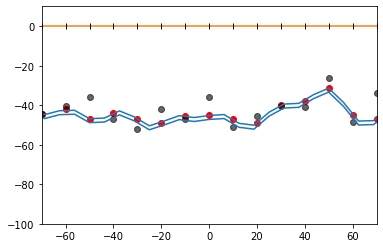

loss tf.Tensor(1.960108894761646, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.6348576   0.39101138 -0.24954999 -0.04102128 -0.24958821 -0.24206594
  0.14276533  0.31698096  0.15586821 -0.08942785  0.62954574  0.16900431
 -0.07462812 -0.64604028 -0.2118843 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.69070151 -42.03931261 -46.807266   -43.92120114 -47.13159093
 -48.81854144 -45.54205324 -45.23670812 -47.15154437 -49.19998394
 -39.81265852 -37.92465285 -31.37312043 -44.99766101 -46.75334906], shape=(15,), dtype=float64)
Iteration 36


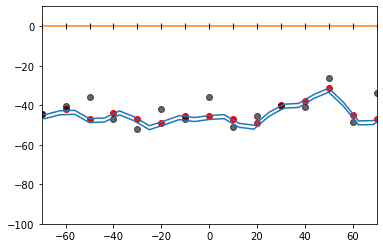

loss tf.Tensor(1.7835710479453155, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.62168883  0.38065203 -0.25311741 -0.04356271 -0.24988525 -0.24412098
  0.13464083  0.30229198  0.1413951  -0.10116982  0.61025401  0.16341176
 -0.06662268 -0.63303541 -0.20052581], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.7528704  -42.07737782 -46.78195426 -43.91684486 -47.1066024
 -48.79412934 -45.55551733 -45.26693732 -47.16568388 -49.18986695
 -39.87368392 -37.94099403 -31.36645816 -44.93435747 -46.73329648], shape=(15,), dtype=float64)
Iteration 37


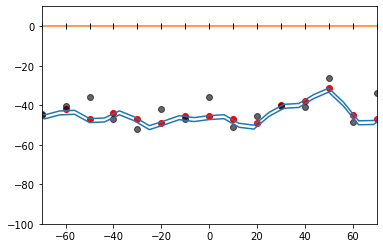

loss tf.Tensor(1.6159645203237005, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.60866934  0.37086697 -0.25630203 -0.04542115 -0.24953339 -0.24523278
  0.12756897  0.28902404  0.12812783 -0.11177909  0.59197493  0.15822943
 -0.05914844 -0.62032652 -0.18996267], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.81373733 -42.11446451 -46.75632406 -43.91230275 -47.08164906
 -48.76960606 -45.56827422 -45.29583972 -47.17849666 -49.17868904
 -39.93288141 -37.95681697 -31.36054331 -44.87232482 -46.71430021], shape=(15,), dtype=float64)
Iteration 38


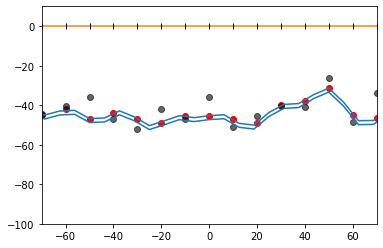

loss tf.Tensor(1.4555385990343552, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.59616306  0.36153446 -0.25892891 -0.04669413 -0.24847408 -0.24556516
  0.12152472  0.27693388  0.11601659 -0.1214763   0.57468421  0.15329191
 -0.05201597 -0.60814247 -0.17978389], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.87335364 -42.15061796 -46.73043117 -43.90763334 -47.05680165
 -48.74504955 -45.58042669 -45.32353311 -47.19009832 -49.16654141
 -39.99034983 -37.97214616 -31.35534172 -44.81151057 -46.69632182], shape=(15,), dtype=float64)
Iteration 39


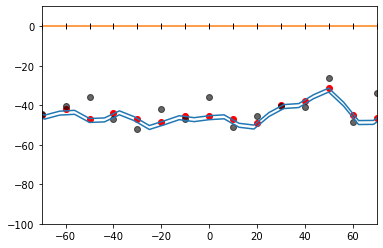

loss tf.Tensor(1.3013544176392315, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.58425032  0.35257801 -0.26099751 -0.04748019 -0.24675721 -0.24524554
  0.11642204  0.26586581  0.10498078 -0.1303786   0.55833904  0.14854766
 -0.0451322  -0.59652676 -0.16983182], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.93177867 -42.18587576 -46.70433142 -43.90288532 -47.03212593
 -48.72052499 -45.5920689  -45.35011969 -47.2005964  -49.15350355
 -40.04618374 -37.98700093 -31.3508285  -44.7518579  -46.67933864], shape=(15,), dtype=float64)
Iteration 40


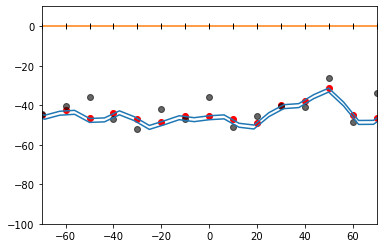

loss tf.Tensor(1.1524821065906394, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.5730526   0.34394732 -0.26246484 -0.04782838 -0.24440456 -0.24436218
  0.11218969  0.25568286  0.0949377  -0.13860682  0.54287426  0.14391533
 -0.03845047 -0.58554676 -0.15998186], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-44.98908393 -42.22027049 -46.67808493 -43.89810248 -47.00768548
 -48.69608878 -45.60328787 -45.37568798 -47.21009017 -49.13964287
 -40.10047116 -38.00139246 -31.34698345 -44.69330322 -46.66334045], shape=(15,), dtype=float64)
Iteration 41


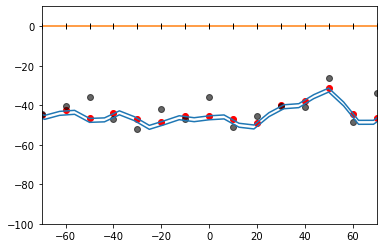

loss tf.Tensor(1.010418670162693, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.56192252  0.33573069 -0.26376632 -0.04779863 -0.24175205 -0.24293408
  0.10855529  0.24643404  0.08567669 -0.14603887  0.52813018  0.13961006
 -0.03219655 -0.57476448 -0.15079642], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.04527618 -42.25384356 -46.6517083  -43.89332262 -46.98351027
 -48.67179537 -45.6141434  -45.40033138 -47.21865784 -49.12503899
 -40.15328418 -38.01535347 -31.34376379 -44.63582677 -46.64826081], shape=(15,), dtype=float64)
Iteration 42


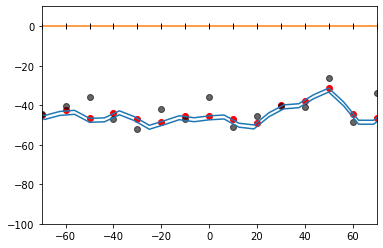

loss tf.Tensor(0.8751140694402864, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.55076936  0.32792456 -0.26498137 -0.0474357  -0.23889008 -0.24102068
  0.10541369  0.23804694  0.07709812 -0.15271854  0.51402868  0.13563834
 -0.02639299 -0.56410707 -0.14233505], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.10035311 -42.28663602 -46.62521016 -43.88857905 -46.95962126
 -48.6476933  -45.62468477 -45.42413607 -47.22636765 -49.10976713
 -40.20468705 -38.0289173  -31.3411245  -44.57941607 -46.6340273 ], shape=(15,), dtype=float64)
Iteration 43


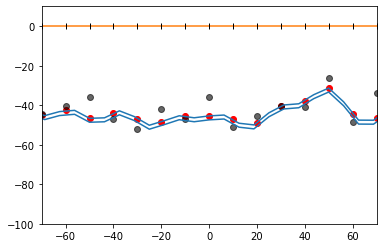

loss tf.Tensor(0.7454698269014273, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.5398369   0.32046272 -0.26598158 -0.04678206 -0.23576477 -0.23870999
  0.10276224  0.23037795  0.06917661 -0.15878421  0.50055321  0.1318888
 -0.02092281 -0.55372386 -0.13433637], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.1543368  -42.31868229 -46.598612   -43.88390084 -46.93604479
 -48.6238223  -45.63496099 -45.44717387 -47.23328531 -49.09388871
 -40.25474237 -38.04210618 -31.33903221 -44.52404368 -46.62059367], shape=(15,), dtype=float64)
Iteration 44


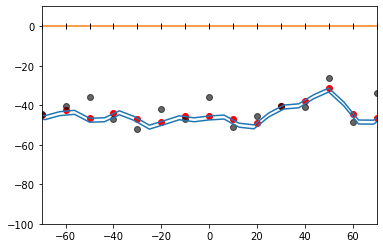

loss tf.Tensor(0.6205312448796008, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.52930135  0.31327761 -0.26668312 -0.04589127 -0.23234617 -0.2360857
  0.10059162  0.22330784  0.06189185 -0.16434372  0.48769861  0.12828388
 -0.0156755  -0.54372277 -0.12658193], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.20726694 -42.35001005 -46.57194369 -43.87931171 -46.91281017
 -48.60021373 -45.64502015 -45.46950465 -47.2394745  -49.07745434
 -40.30351223 -38.05493457 -31.33746467 -44.4696714  -46.60793547], shape=(15,), dtype=float64)
Iteration 45


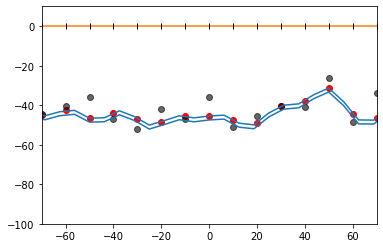

loss tf.Tensor(0.499541467114085, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.5192734   0.30631494 -0.26703955 -0.04481011 -0.22862637 -0.23321516
  0.09888149  0.21674434  0.05521744 -0.1694779   0.47545279  0.12477022
 -0.01057347 -0.53416979 -0.11892353], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.25919428 -42.38064154 -46.54523974 -43.8748307  -46.88994753
 -48.57689221 -45.6549083  -45.49117909 -47.24499624 -49.06050655
 -40.35105751 -38.06741159 -31.33640732 -44.41625442 -46.59604312], shape=(15,), dtype=float64)
Iteration 46


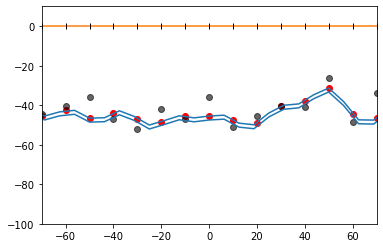

loss tf.Tensor(0.3818336729158318, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.50985352  0.29954113 -0.2670028  -0.04355806 -0.22459758 -0.23014202
  0.09760853  0.21061188  0.04911778 -0.1742602   0.46378515  0.12129017
 -0.00557861 -0.52512276 -0.11126287], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.31017963 -42.41059566 -46.51853946 -43.8704749  -46.86748777
 -48.55387801 -45.66466915 -45.51224027 -47.24990802 -49.04308053
 -40.39743603 -38.07954061 -31.33584946 -44.36374215 -46.58491683], shape=(15,), dtype=float64)
Iteration 47


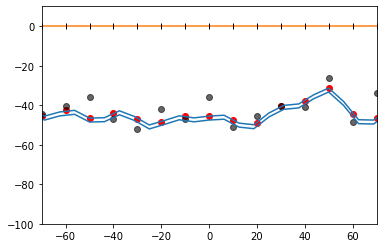

loss tf.Tensor(0.2688789108470928, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.50051203  0.29303091 -0.26691984 -0.04217195 -0.22051469 -0.22686195
  0.0965791   0.20497362  0.043445   -0.17857639  0.45257656  0.11802137
 -0.00088278 -0.51623525 -0.10406122], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.36023083 -42.43989875 -46.49184747 -43.8662577  -46.84543631
 -48.53119182 -45.67432706 -45.53273764 -47.25425252 -49.02522289
 -40.44269368 -38.09134275 -31.33576118 -44.31211862 -46.57451071], shape=(15,), dtype=float64)
Iteration 48


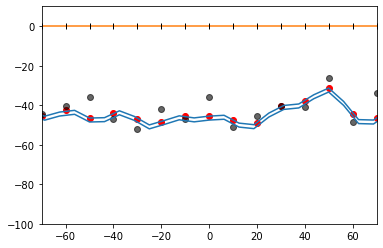

loss tf.Tensor(0.16087029829870403, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.49113952  0.28679476 -0.26686677 -0.04067073 -0.21644604 -0.22339603
  0.09572445  0.19980667  0.03813418 -0.18243342  0.44177133  0.11498613
  0.00347524 -0.50742873 -0.0974079 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.40934479 -42.46857822 -46.4651608  -43.86219063 -46.8237917
 -48.50885221 -45.68389951 -45.5527183  -47.25806594 -49.00697955
 -40.48687082 -38.10284136 -31.3361087  -44.26137575 -46.56476992], shape=(15,), dtype=float64)
Iteration 49


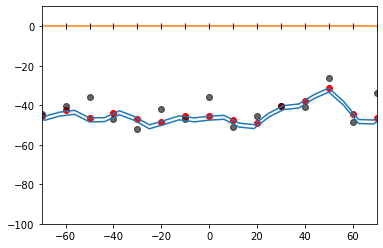

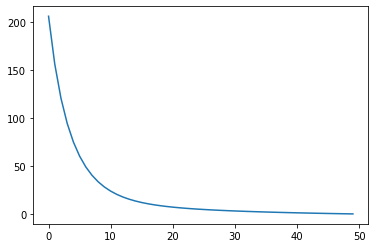

In [47]:
lost = []
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = negative_log_posterior(D,mu) # negative log posterior
        lost.append(loss.numpy())
        dlossdmu = t.gradient(loss,mu)
        print('loss',loss)
        print('grad',dlossdmu)
    mu = mu-tf.multiply(constant64(0.1),dlossdmu)
    print('mu:',mu)
    f,ax = plt.subplots()
    Draw_inter(control_index,mu,ax = ax)
    print('Iteration',i)
    plt.show()
plt.plot(lost)

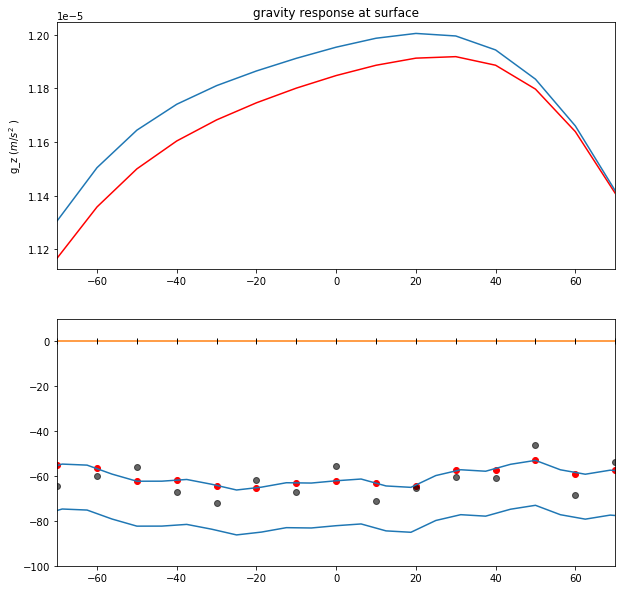

In [33]:
f,ax = plt.subplots(2,figsize =(10,10))
ax[0].plot(x_obs,D,'r')
Draw(control_index,mu,ax)

In [34]:
MAP = mu

In [35]:
negative_log_posterior(D,mu)

<tf.Tensor: shape=(), dtype=float64, numpy=-178.50413243487404>

### Random Walk MCMC

In [ ]:
# num_results = number_sample
# burnin = number_burnin

num_results=2
burnin = 0

initial_chain_state = [
    -50 * tf.ones([Number_para], dtype=tf.float64, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_post(D,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float64

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [ ]:
samples

In [ ]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

In [ ]:
print('Acceptance rate = %0.1f%%' % (100*accepted_samples.shape[0]/num_results))

In [ ]:
#TODO
def draw_MCMC(samples,Truth = None,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots(figsize = (10,5))
    
#     if Truth is not None:
#         draw(base,Truth,ax = ax, R = R)
            
    x_cor = tf.linspace(constant64(-70),constant64(70),Number_para)
    
    for ps in samples:
        ax.plot(x_cor,ps,'r.',alpha =0.2)
        ps = tf.reshape(ps,[ps.shape[0]])
        GaussianProcess_model_plot(control_index,ps,ax = ax, alpha = 0.2)
    ax.set_ylim(-70,0)
    ax.set_xlim(-R,R)

In [ ]:
draw_MCMC(samples) # [:,:,0] transpost the results for plotting

In [ ]:
corner.corner(accepted_samples[:,:,0])

# Hessian Method

### Could be parelized?

In [ ]:
with tf.GradientTape() as t:
    t.watch(MAP)
    with tf.GradientTape() as tt:
        tt.watch(MAP)
        loss = negative_log_posterior(D,MAP)
    jac = tt.gradient(loss,MAP,unconnected_gradients='zero')
hess = t.gradient(jac,MAP,unconnected_gradients = 'none')

In [ ]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para)
    j=0
    for i in range(Number_para):
        print(j)
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = negative_log_posterior(D,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()

New_Hessian = Full_Hessian()

In [ ]:
plt.imshow(New_Hessian)

In [ ]:
def Laplace_appro(H,C_prior):
    return tf.linalg.inv((tf.add(H,tf.linalg.inv(C_prior))))


In [ ]:
cov_post = Laplace_appro(New_Hessian,cov_prior)

In [ ]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float64)
    matrix2 = tf.cast(matrix2,tf.float64)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(constant64(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.add(negative_log_posterior(D,m_current),matrixcompute(m_current,MAP,cov_post))
    delta_proposed = tf.add(negative_log_posterior(D,m_proposed),matrixcompute(m_proposed,MAP,cov_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(constant64(0), constant64(1)),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        
from IPython.display import clear_output
# define leaning rate
beta = constant64(0.9)

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(tf.sqrt(1-beta**2),dtype = tf.float64)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    
    Xi = tfd.MultivariateNormalTriL(loc=0, scale_tril=tf.linalg.cholesky(cov_post))
    
#     Xi = tfd.MultivariateNormalFullCovariance(
#             loc = 0,
#             covariance_matrix= cov_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed       

In [ ]:
mu_init = -50 * tf.ones([Number_para], dtype=tf.float64)

number_of_steps = number_sample
def run_chain():
    burn_in = number_burnin
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted_gpCN = np.array(accepted)



In [ ]:
draw_MCMC(accepted_gpCN)

### try pCN MCMC

first define a likelihood function rather than posteior function

In [ ]:
def log_likelihood(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_likelihood.log_prob(D))

def negative_likeli(_control_position):
    return tf.negative(log_likelihood(D,_control_position))

In [ ]:
def acceptance_pCN(m_current , m_proposed):
    delta_current = negative_likeli(m_current)
    delta_proposed = negative_likeli(m_proposed)
    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(constant64(0), constant64(1)),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [ ]:
mu_init = -50 * tf.ones([Number_para], dtype=tf.float64)

number_of_steps = number_sample
def run_chain():
    burn_in = number_burnin
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        if acceptance_pCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted_pCN = np.array(accepted)

In [ ]:
draw_MCMC(accepted_pCN)

In [ ]:
corner.corner(accepted_pCN)

In [ ]:
print('run success')